In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, lfilter, decimate, resample_poly, resample, upfirdn, butter, filtfilt
from scipy.stats import zscore
from IPython.display import Audio

# AM Demodulation

## Mathematical Explanation

1. **AM Signal Representation:**
   - AM Signal: $s(t) = (A_c + m(t)) \cdot \cos(2\pi f_c t)$
     - Where $s(t)$ is the AM signal, $A_c$ is the amplitude of the carrier wave, $m(t)$ is the message signal, and $f_c$ is the carrier frequency.
2. **Envelope Detection:**
   - Simplest form of demodulation.
   - Rectify and smooth the AM signal.
   - Rectified Signal: $|s(t)| = |(A_c + m(t)) \cdot \cos(2\pi f_c t)|$
   - After smoothing and removing DC offset, the message signal $m(t)$ is recovered.
3. **Synchronous Detection:**
   - Involves mixing the AM signal with a local carrier of the same frequency and phase.
   - Demodulated Signal: $s(t) \cdot \cos(2\pi f_c t) = (A_c + m(t)) \cdot \cos^2(2\pi f_c t)$
   - Using trigonometric identities, the signal can be expressed as: $\frac{1}{2}(A_c + m(t)) + \frac{1}{2}(A_c + m(t))\cos(4\pi f_c t)$
   - This contains a low-frequency component (the desired message signal $m(t)$) and a high-frequency component (twice the carrier frequency).
   - A low-pass filter removes the high-frequency component, yielding: $\frac{1}{2}(A_c + m(t))$
   - Removing the DC offset, the original message signal $m(t)$ is recovered.

In [2]:
signal = np.load('signal_-10.npy')
fs = 6.25E6  # Sample rate in Hz
t = np.arange(0, 1, 1/fs)  # Time vector for 1 second

In [3]:
with np.load('Lowpass_dec.npz') as data:
    ba = data['ba']

In [4]:
signal_fil = lfilter(ba[0], ba[1], signal)

/home/michael/miniforge3/envs/gnuradio/lib/python3.12/site-packages/matplotlib/axes/_axes.py:7408: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)


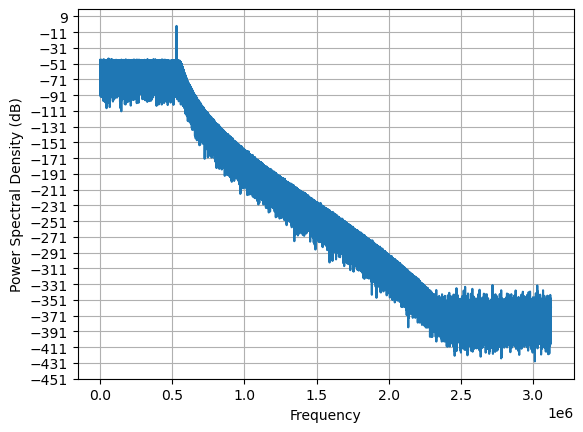

In [5]:
plt.figure()
plt.psd(signal_fil, Fs=fs, NFFT=len(signal_fil), scale_by_freq=False)
plt.show()

In [6]:
dec = 4
signal_dec1 = decimate(signal_fil, dec)
t_dec = np.arange(0, 1, 1/(fs/4))  # Time vector for 1 second

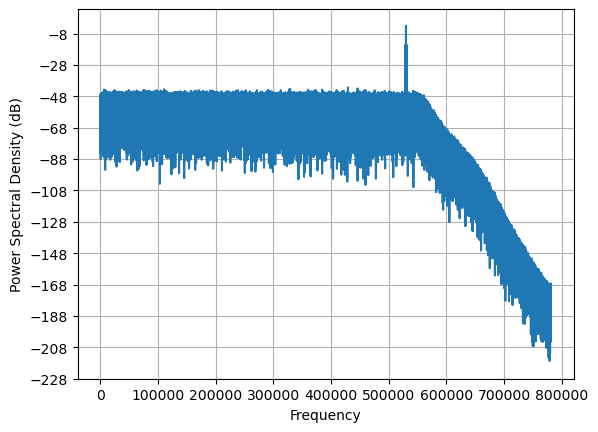

In [7]:
plt.figure()
Pxx_dec, f = plt.psd(signal_dec1, Fs=fs/4, NFFT=1048576, scale_by_freq=False)
plt.show()

In [8]:
with np.load('Bandpass.npz') as data:
    ba = data['ba']

In [9]:
signal_dec1_fil = lfilter(ba[0], ba[1], signal_dec1)

In [10]:
len(signal_dec1_fil)

1562500

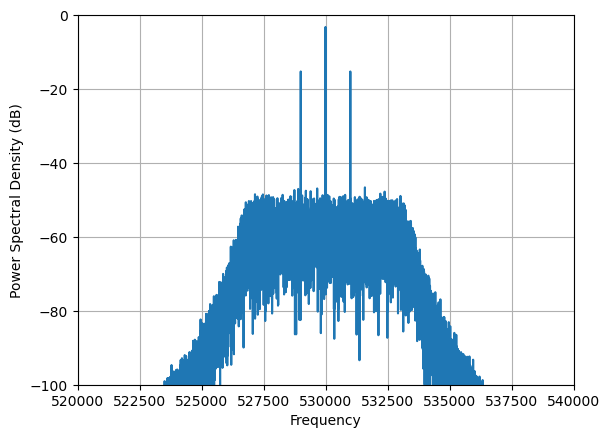

In [11]:
plt.figure()
Pxx_dec, f = plt.psd(signal_dec1_fil, Fs=fs/4, NFFT=1562500, scale_by_freq=False)
plt.xlim(520000, 540000)
plt.ylim(-100, 0)
plt.show()

In [12]:
sig_fin = signal_dec1_fil[::35]

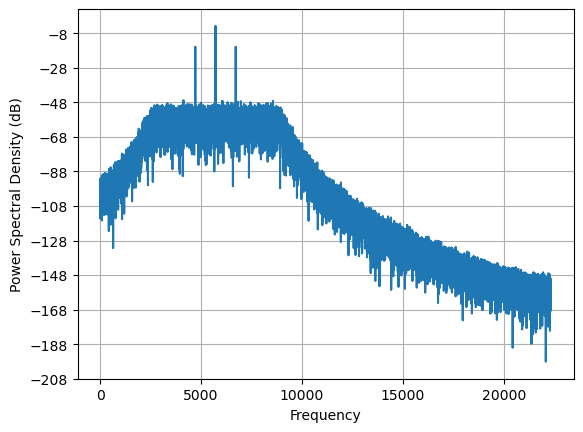

In [13]:
plt.figure()
plt.psd(sig_fin, Fs=len(sig_fin), NFFT=len(sig_fin), scale_by_freq=False)
plt.show()

In [14]:
sig_aud_fs = resample(sig_fin, 44100)

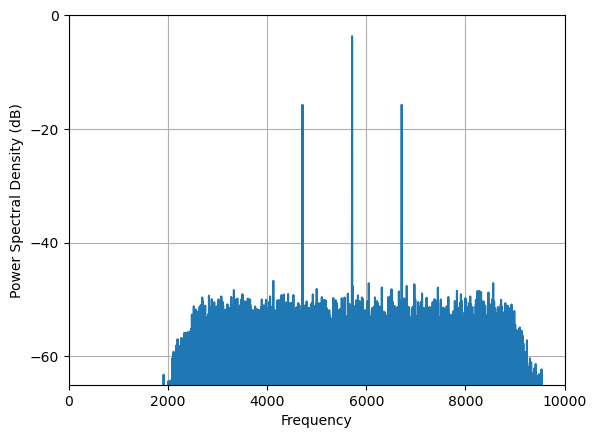

In [15]:
plt.figure()
plt.psd(sig_aud_fs, Fs=44100, NFFT=44100, scale_by_freq=False)
plt.ylim(-65, 0)
plt.xlim(0, 10000)
plt.show()

In [16]:
# 1. Rectification
rectified_AM = np.abs(sig_aud_fs)

# 2. Filtering
with np.load('aud_fil.npz') as data:
    ba = data['ba']

# Apply the filter to the rectified signal
filtered_message = filtfilt(ba[0], ba[1], rectified_AM)

# 3. DC Removal
# Assuming the message has zero DC component, the DC component in the rectified signal is approximately Ac.
# We subtract this to get the demodulated message signal
Ac = np.mean(filtered_message)
demodulated_message = filtered_message - Ac

In [17]:
audio_player_dsp = Audio(demodulated_message, rate=44100)

audio_player_dsp

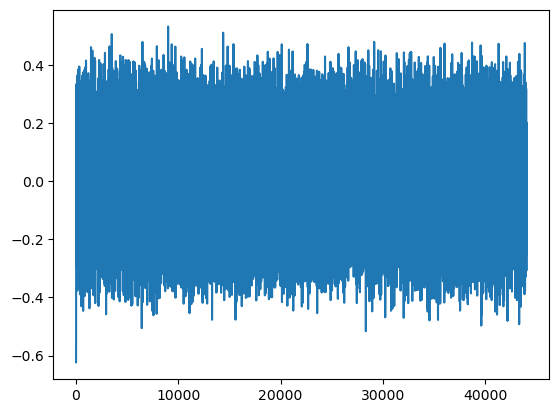

In [18]:
plt.figure()
plt.plot(demodulated_message)
plt.show()

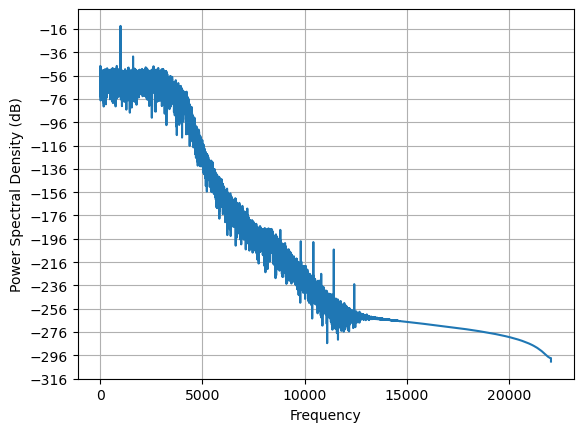

In [19]:
plt.figure()
plt.psd(demodulated_message, Fs=44100, NFFT=44100, scale_by_freq=False)
plt.show()